In [1]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from langdetect import detect, DetectorFactory
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from tqdm import tqdm
from wordcloud import WordCloud
import nest_asyncio
import praw

nest_asyncio.apply()

nltk.download("vader_lexicon")
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\raize\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\raize\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\raize\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\raize\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')

In [35]:
reddit = praw.Reddit(
    client_id="",
    client_secret="",
    user_agent="",
)

In [4]:
print(reddit.read_only)

True


In [5]:
reddit

In [6]:
subreddit = reddit.subreddit("movies")

reviews = []
for submission in subreddit.new(limit=100):  # You can adjust the limit
    # if "review" in submission.title.lower():
    #     reviews.append(submission.selftext)  # selftext is the post body
    # keywords = ["review", "thoughts", "opinion", "watched"]
    # if any(kw in submission.title.lower() for kw in keywords):
    #     reviews.append(submission.selftext)
    if submission.selftext:  # Only collect non-empty posts
        reviews.append(submission.selftext)

print(f"Collected {len(reviews)} reviews.")

Collected 65 reviews.


In [7]:
# reviews[:5]

In [8]:
subreddit = reddit.subreddit("movies")
reviews = []

inception_keywords = ["inception", "INCEPTION", "inception movie"]

for submission in subreddit.new(limit=200):  # You can increase the limit for better coverage
    title = submission.title.lower()
    body = submission.selftext.lower()
    
    if any(kw in title or kw in body for kw in inception_keywords):
        if submission.selftext.strip():  # Make sure it's not empty
            reviews.append(submission.selftext.strip())

print(f"Collected {len(reviews)} Inception-related reviews/posts.")

Collected 0 Inception-related reviews/posts.


In [9]:
subreddit = reddit.subreddit("Inception")

In [10]:
for submission in subreddit.new(limit=500):  # Adjust the limit as needed
    if submission.selftext:
        reviews.append(submission.selftext)

print('Collected: ', len(reviews), 'Inception-related reviews/posts.')

Collected:  325 Inception-related reviews/posts.


In [11]:
DetectorFactory.seed = 0  # To make detection more consistent

reviews = []

for submission in subreddit.new(limit=500):
    if submission.selftext:
        try:
            if detect(submission.selftext) == 'en':
                reviews.append(submission.selftext)
        except:
            pass  # Skip if language detection fails (e.g., very short text)

print('Collected:', len(reviews), 'English Inception-related reviews/posts.')

Collected: 306 English Inception-related reviews/posts.


In [12]:
reviews[:2]

['If I had money I’d get someone to build me a Bluetooth music player that looks exactly like a pasiv but instead of IVs it lets multiple people plug in headphones or whatever to listen to the same thing like it wouldn’t even be practical but it would be fun to have lol',
 'When the van would have hit the water surface, they would have felt the falling sensation anyway and woken up. They just needed to be floating above the hotel bed']

In [13]:
analyzer = SentimentIntensityAnalyzer()

for review in reviews[:5]:  # Show a few examples
    scores = analyzer.polarity_scores(review)
    print('Sentiment: ', scores)

Sentiment:  {'neg': 0.0, 'neu': 0.778, 'pos': 0.222, 'compound': 0.9209}
Sentiment:  {'neg': 0.052, 'neu': 0.948, 'pos': 0.0, 'compound': -0.1531}
Sentiment:  {'neg': 0.063, 'neu': 0.747, 'pos': 0.19, 'compound': 0.7438}
Sentiment:  {'neg': 0.128, 'neu': 0.788, 'pos': 0.084, 'compound': -0.8294}
Sentiment:  {'neg': 0.0, 'neu': 0.94, 'pos': 0.06, 'compound': 0.4019}


In [14]:
analyzer = SentimentIntensityAnalyzer()

for i, review in enumerate(reviews[:5]):  # Show a few examples
    scores = analyzer.polarity_scores(review)
    print(f"Review {i+1} Sentiment: {scores}")

Review 1 Sentiment: {'neg': 0.0, 'neu': 0.778, 'pos': 0.222, 'compound': 0.9209}
Review 2 Sentiment: {'neg': 0.052, 'neu': 0.948, 'pos': 0.0, 'compound': -0.1531}
Review 3 Sentiment: {'neg': 0.063, 'neu': 0.747, 'pos': 0.19, 'compound': 0.7438}
Review 4 Sentiment: {'neg': 0.128, 'neu': 0.788, 'pos': 0.084, 'compound': -0.8294}
Review 5 Sentiment: {'neg': 0.0, 'neu': 0.94, 'pos': 0.06, 'compound': 0.4019}


In [15]:
inception = pd.DataFrame({'reviews':reviews})
inception.head()

,reviews
0,If I had money I’d get someone to build me a B...
1,"When the van would have hit the water surface,..."
2,"In base reality, they have a machine that allo..."
3,Just watched Inception again. I am actually ta...
4,At first I thought it was the same scene and i...


In [37]:
vader = SentimentIntensityAnalyzer()

In [38]:
inception['vader_score'] = inception['reviews'].apply(lambda x: vader.polarity_scores(x))
inception['vader_score']

0      {'neg': 0.0, 'neu': 0.778, 'pos': 0.222, 'comp...
1      {'neg': 0.052, 'neu': 0.948, 'pos': 0.0, 'comp...
2      {'neg': 0.063, 'neu': 0.747, 'pos': 0.19, 'com...
3      {'neg': 0.128, 'neu': 0.788, 'pos': 0.084, 'co...
4      {'neg': 0.0, 'neu': 0.94, 'pos': 0.06, 'compou...
                             ...                        
301    {'neg': 0.121, 'neu': 0.879, 'pos': 0.0, 'comp...
302    {'neg': 0.061, 'neu': 0.808, 'pos': 0.131, 'co...
303    {'neg': 0.038, 'neu': 0.923, 'pos': 0.038, 'co...
304    {'neg': 0.056, 'neu': 0.806, 'pos': 0.138, 'co...
305    {'neg': 0.135, 'neu': 0.75, 'pos': 0.116, 'com...
Name: vader_score, Length: 306, dtype: object

In [47]:
inception['vader_score'][0]
# inception['vader_score'].keys()

{'neg': 0.0, 'neu': 0.778, 'pos': 0.222, 'compound': 0.9209}

In [41]:
#add vader scores into the Inception dataframe
inception['positive sentiment score'] = inception['reviews'].apply(lambda x: vader.polarity_scores(x)['pos'])
inception['negative sentiment score'] = inception['reviews'].apply(lambda x: vader.polarity_scores(x)['neg'])
inception['neutral sentiment score'] = inception['reviews'].apply(lambda x: vader.polarity_scores(x)['neu'])
inception['compound_score'] = inception['reviews'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [17]:
# Apply sentiment analysis
# inception['compound_score'] = inception['reviews'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Optional: classify sentiment as Positive / Negative / Neutral
def classify_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

inception['sentiment'] = inception['compound_score'].apply(classify_sentiment)

inception[['reviews', 'compound_score', 'sentiment']].head()

,reviews,compound_score,sentiment
0,If I had money I’d get someone to build me a B...,0.9209,Positive
1,"When the van would have hit the water surface,...",-0.1531,Negative
2,"In base reality, they have a machine that allo...",0.7438,Positive
3,Just watched Inception again. I am actually ta...,-0.8294,Negative
4,At first I thought it was the same scene and i...,0.4019,Positive


In [18]:
inception.shape

(306, 3)

In [42]:
inception.head()

,reviews,compound_score,sentiment,split_review,vader_score,positive sentiment score,negative sentiment score,neutral sentiment score
0,If I had money I’d get someone to build me a B...,0.9209,Positive,"[If, I, had, money, I’d, get, someone, to, bui...","{'neg': 0.0, 'neu': 0.778, 'pos': 0.222, 'comp...",0.222,0.000,0.778
1,"When the van would have hit the water surface,...",-0.1531,Negative,"[When, the, van, would, have, hit, the, water,...","{'neg': 0.052, 'neu': 0.948, 'pos': 0.0, 'comp...",0.000,0.052,0.948
2,"In base reality, they have a machine that allo...",0.7438,Positive,"[In, base, reality,, they, have, a, machine, t...","{'neg': 0.063, 'neu': 0.747, 'pos': 0.19, 'com...",0.190,0.063,0.747
3,Just watched Inception again. I am actually ta...,-0.8294,Negative,"[Just, watched, Inception, again., I, am, actu...","{'neg': 0.128, 'neu': 0.788, 'pos': 0.084, 'co...",0.084,0.128,0.788
4,At first I thought it was the same scene and i...,0.4019,Positive,"[At, first, I, thought, it, was, the, same, sc...","{'neg': 0.0, 'neu': 0.94, 'pos': 0.06, 'compou...",0.060,0.000,0.940


In [ ]:
inception.to_csv('data/inception.csv')

In [20]:
#creating a stop words list - these words don't add much value
from nltk.corpus import stopwords
import string

#adding additional words I don't find to be that valuable
additional_stopwords = ['https', 'I', 'com', 'http', 'RT', 'co', 'the', 'amp', 'the', 'lt', 'A', 'www', 'rt', 'got', 'get', 
                        'ly', 'u']

stopwords_list = stopwords.words('english')

stopwords_list += list(string.punctuation)

stopwords_list += additional_stopwords

print(stopwords_list)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [27]:
#isolating every word within tweets for the Inception movie (not including stop words)
# Split each review into words
inception["split_review"] = inception['reviews'].str.split()

In [29]:
inception.shape
inception.head()

,reviews,compound_score,sentiment,split_review
0,If I had money I’d get someone to build me a B...,0.9209,Positive,"[If, I, had, money, I’d, get, someone, to, bui..."
1,"When the van would have hit the water surface,...",-0.1531,Negative,"[When, the, van, would, have, hit, the, water,..."
2,"In base reality, they have a machine that allo...",0.7438,Positive,"[In, base, reality,, they, have, a, machine, t..."
3,Just watched Inception again. I am actually ta...,-0.8294,Negative,"[Just, watched, Inception, again., I, am, actu..."
4,At first I thought it was the same scene and i...,0.4019,Positive,"[At, first, I, thought, it, was, the, same, sc..."


In [30]:
inception = inception[~inception['split_review'].isin(stopwords_list)]

In [31]:
inception.shape

(306, 4)

In [48]:
# Let's assume your DataFrame is named df and 'split_review' is already a list of words
# Flatten all lists from the split_review column
all_words = [word for sublist in inception['split_review'] for word in sublist]

# Convert stopwords to a set for faster lookup
stop_words = set(stopwords.words('english'))

# Remove stopwords and lowercase the words
filtered_words = [word.lower() for word in all_words if word.lower() not in stop_words]

# Create frequency distribution
fdist = FreqDist(filtered_words)

# Now you can inspect fdist
print(fdist.most_common(10))  # Top 10 most frequent words

[('cobb', 346), ('dream', 241), ('mal', 153), ('movie', 151), ('would', 129), ('saito', 126), ('know', 125), ('limbo', 125), ('like', 116), ('time', 110)]


In [63]:
# Step 1: Flatten the split_review column into one list of words with a DataFrame
words_df = inception['split_review'].explode().to_frame(name='word')

# Step 2: Lowercase words and filter out stopwords using `isin`
stop_words = set(stopwords.words('english'))
words_df['word'] = words_df['word'].str.lower()
filtered_df = words_df[~words_df['word'].isin(stop_words)]

# Step 3: Get word frequency using value_counts
fdist = filtered_df['word'].value_counts()

# Optional: Convert to dictionary or inspect top words
print(fdist.head(10))

word
cobb     346
dream    241
mal      153
movie    151
would    129
saito    126
limbo    125
know     125
like     116
time     110
Name: count, dtype: int64


In [64]:
# inception_words = inception['split_review'].explode().reset_index(drop=True)
# inception['split_review'].explode().reset_index()
# pd.DataFrame(inception['split_review'].explode())
# words_df.head()
# pd.DataFrame(inception['split_review'].explode().rename(columns={'split_review':'word'})

In [33]:
#freqDist - frequency of words within a text, in this case tweets about Inception
# fdist = FreqDist(inception['split_review'][0])

In [65]:
# fdist.most_common(2)

C:\Users\raize\AppData\Local\Temp\ipykernel_32272\2983375865.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(inception['vader_score'], color = 'firebrick')


TypeError: float() argument must be a string or a real number, not 'dict'

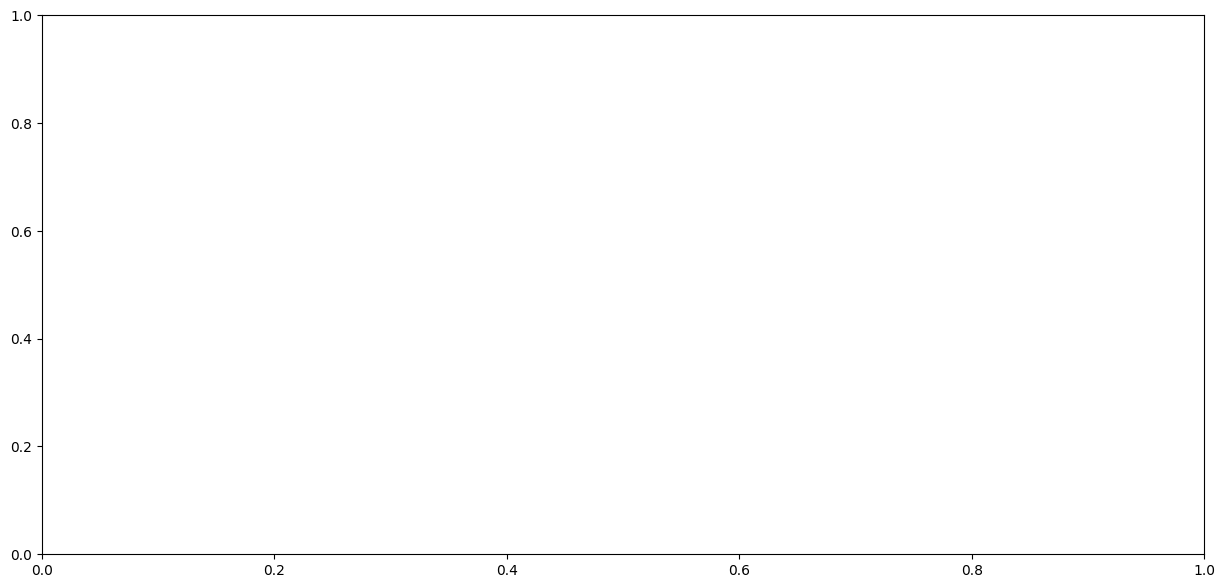

In [69]:
#distribution of vader score
fig, ax = plt.subplots(figsize=(15,7))
ax = sns.distplot(inception['vader_score'], color = 'firebrick')
plt.xlabel('Sentiment Score', fontsize=18)
plt.ylabel('Tweets per Score', fontsize=18)
plt.title('VADER Sentiment of Inception', fontsize=22)
plt.tick_params(labelsize='large')

plt.savefig('images/VADERinception.jpg')

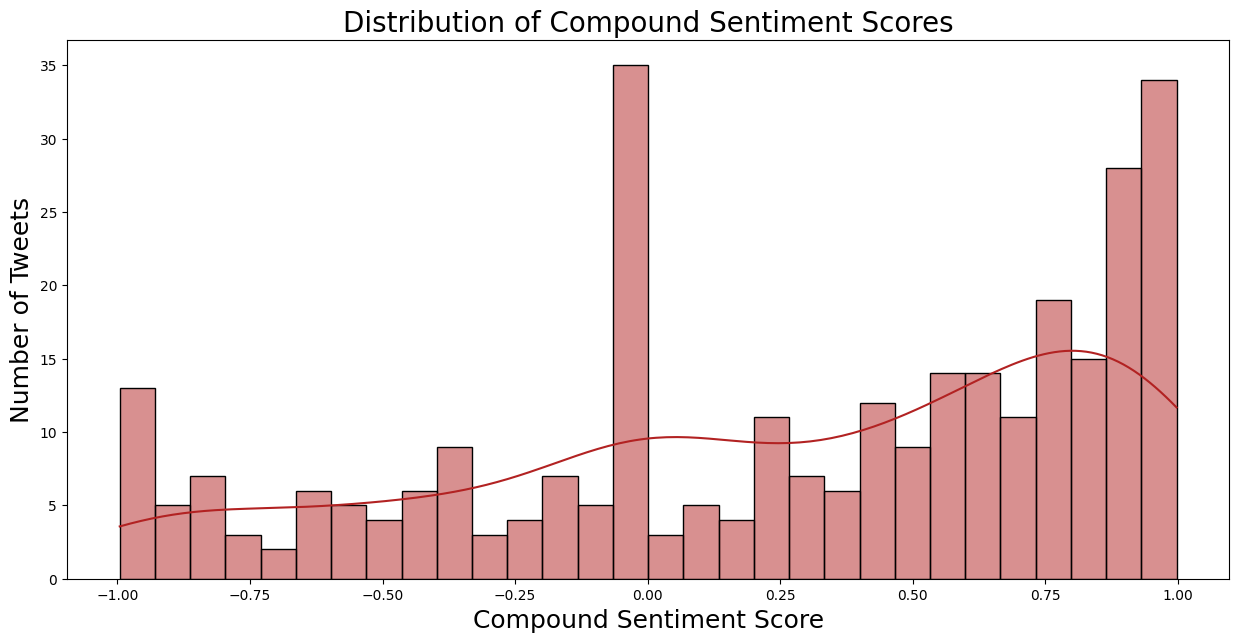

<Figure size 640x480 with 0 Axes>

In [74]:
# Extract compound scores into a new column
inception['compound'] = inception['vader_score'].apply(lambda x: x['compound'] if isinstance(x, dict) else None)

# Plot the distribution
plt.figure(figsize=(15,7))
sns.histplot(inception['compound'].dropna(), color='firebrick', bins=30, kde=True)
plt.xlabel('Compound Sentiment Score', fontsize=18)
plt.ylabel('Number of Tweets', fontsize=18)
plt.title('Distribution of Compound Sentiment Scores', fontsize=20)
plt.show()

plt.savefig('Reddit_NLP_Sentiment/images/VADERinception.jpg')

In [76]:
inception.head(2)

,reviews,compound_score,sentiment,split_review,vader_score,positive sentiment score,negative sentiment score,neutral sentiment score,compound
0,If I had money I’d get someone to build me a B...,0.9209,Positive,"[If, I, had, money, I’d, get, someone, to, bui...","{'neg': 0.0, 'neu': 0.778, 'pos': 0.222, 'comp...",0.222,0.000,0.778,0.9209
1,"When the van would have hit the water surface,...",-0.1531,Negative,"[When, the, van, would, have, hit, the, water,...","{'neg': 0.052, 'neu': 0.948, 'pos': 0.0, 'comp...",0.000,0.052,0.948,-0.1531


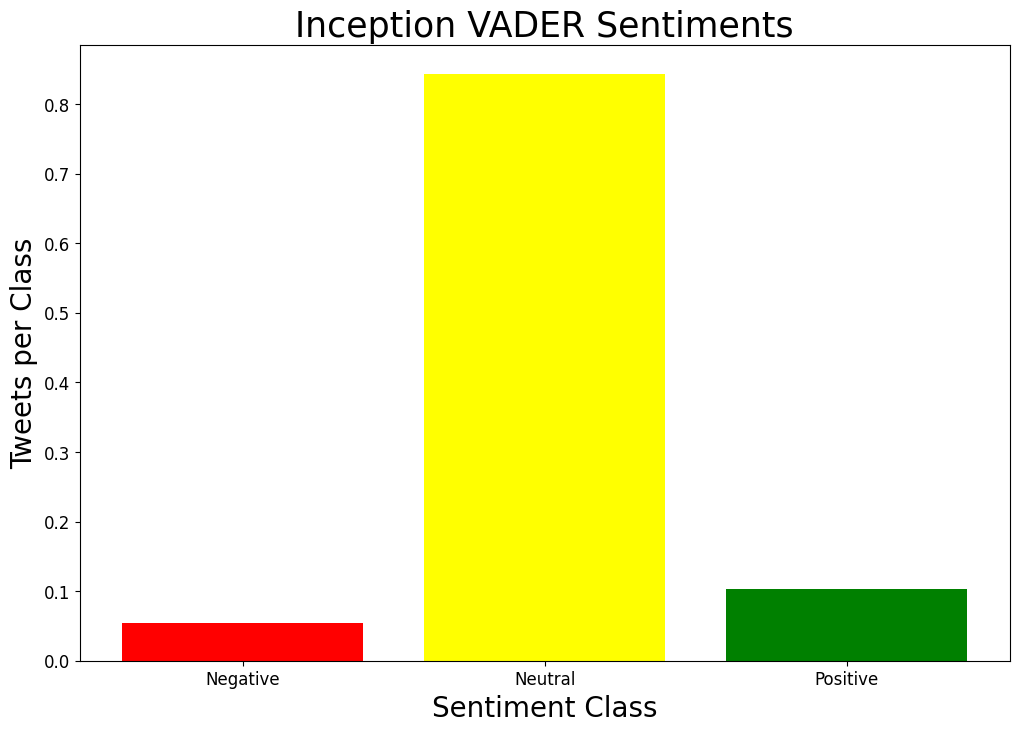

In [80]:
#bar plot representation of negative, neutral, and positive vader scores

avg_scores = {
    'Negative': inception['negative sentiment score'].mean(),
    'Neutral': inception['neutral sentiment score'].mean(),
    'Positive': inception['positive sentiment score'].mean()
}

fig, ax = plt.subplots(figsize=(12,8))
ax.bar(avg_scores.keys(), avg_scores.values(), color =['red', 'yellow', 'green'])
plt.title('Inception VADER Sentiments', fontsize=25)
plt.xlabel('Sentiment Class', fontsize=20)
plt.ylabel('Tweets per Class', fontsize=20)
plt.tick_params(labelsize='large')

# plt.savefig('Reddit_NLP_Sentiment/images/inceptionsentiments.jpg')

## LDA & TSNE